In [362]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings

import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# close warnings
warnings.filterwarnings('ignore')

In [363]:
data = pd.read_csv('StateMfgData.csv')
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)

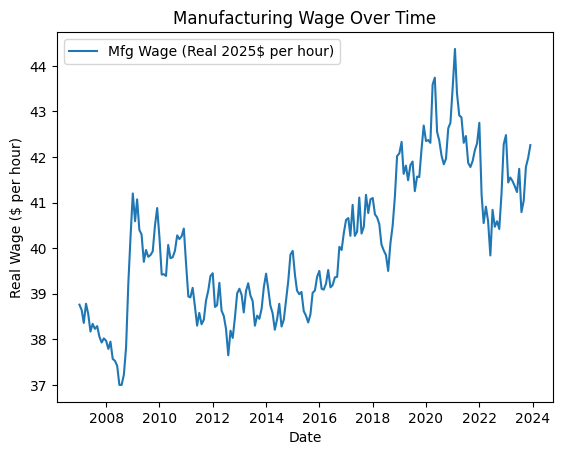

In [364]:
plt.plot(data['Mfg Wage ($/hour)'], label='Mfg Wage (Real 2025$ per hour)')
plt.title('Manufacturing Wage Over Time')
plt.xlabel('Date')
plt.ylabel('Real Wage ($ per hour)')
plt.legend()
plt.show()

In [365]:
adf_test = adfuller(data['Mfg Wage ($/hour)'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -1.587254
p-value: 0.489993


In [366]:
new_array = statsmodels.tsa.statespace.tools.diff(data['Mfg Wage ($/hour)'], k_diff=1, k_seasonal_diff=None, seasonal_periods=1)

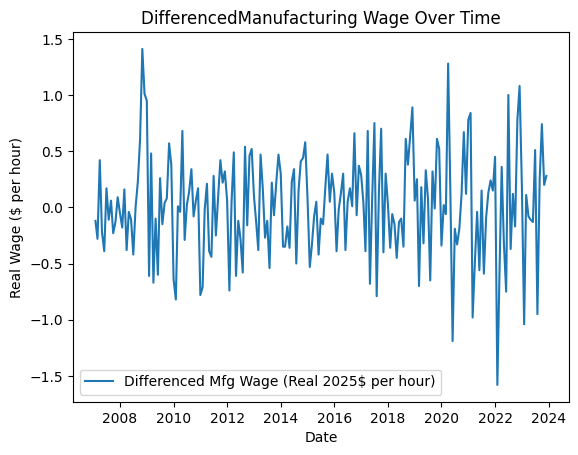

In [367]:
plt.plot(new_array, label='Differenced Mfg Wage (Real 2025$ per hour)')
plt.title('DifferencedManufacturing Wage Over Time')
plt.xlabel('Date')
plt.ylabel('Real Wage ($ per hour)')
plt.legend()
plt.show()

In [368]:
adf_test = adfuller(new_array)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.236417
p-value: 0.000571


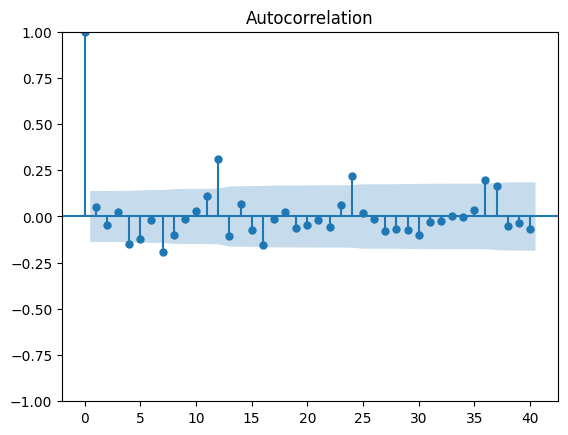

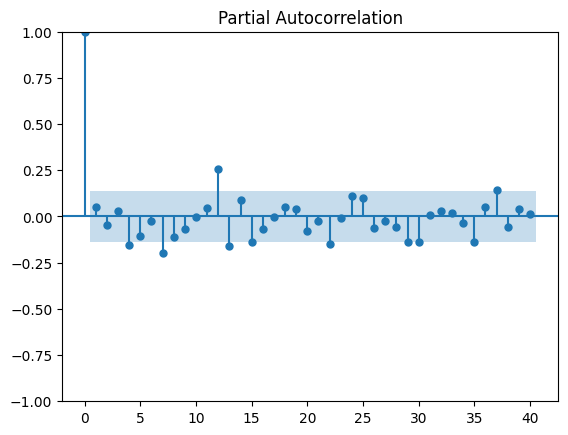

In [369]:
plot_acf(new_array, lags=40)
plot_pacf(new_array, lags=40)
plt.show()

ACF : 
Is the observed time series white noise / random? Non-random
Is an observation related to an adjacent observation, an observation twice-removed, and so on? observation ~12 times removed
Can the observed time series be modeled with an MA model? If yes, what is the order? idk

PACF:
Can the observed time series be modeled with an AR model? If yes, what is the order?

Furthermore, you will see a blue area in the ACF and PACF plots, which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

seems to peak each 12 (which correlates with annual)

probably seasonal AR(1) S = 12

seasonal arima 

order of autoregression (p)
the degree of differencing (d) = 1
order of moving average (q)


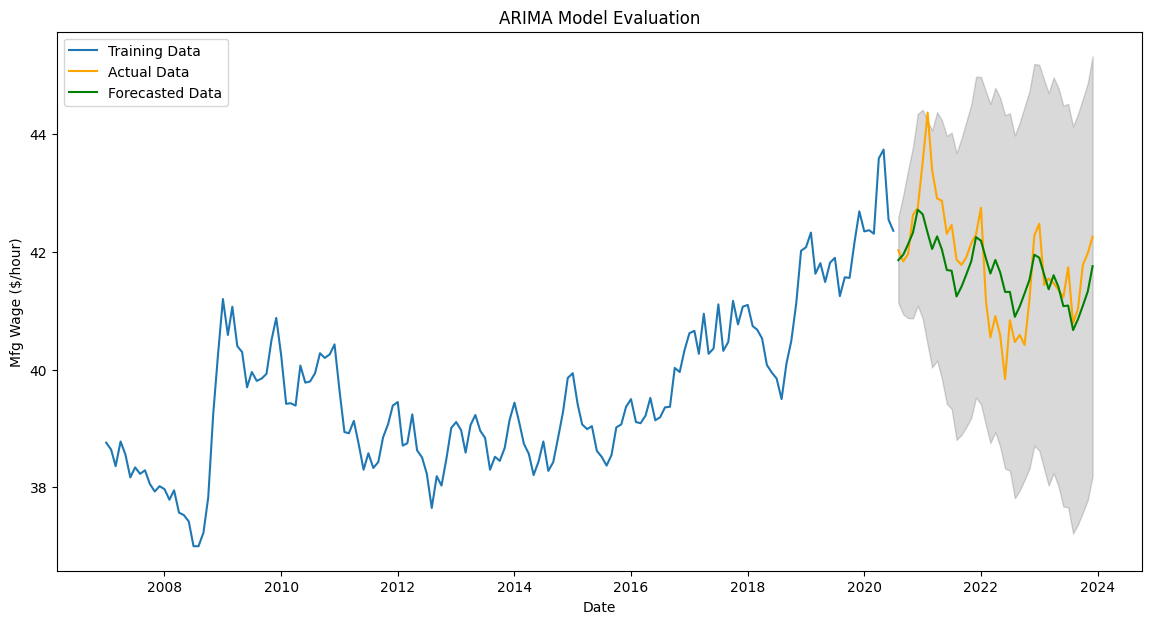

RMSE: 0.6927667893313774


In [370]:
# Split the data into train and test
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:len(data)]

# Fit the ARIMA model on the training dataset
model_train = ARIMA(train['Mfg Wage ($/hour)'], seasonal_order=(0, 1, 1, 12), order=(4, 0, 0))
model_train_fit = model_train.fit()

# Forecast on the test dataset
test_forecast = model_train_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)

# Calculate the mean squared error
mse = mean_squared_error(test['Mfg Wage ($/hour)'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['Mfg Wage ($/hour)'], label='Training Data')
plt.plot(test['Mfg Wage ($/hour)'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 test_forecast.conf_int().iloc[:, 0], 
                 test_forecast.conf_int().iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Mfg Wage ($/hour)')
plt.legend()
plt.show()

print('RMSE:', rmse)